# Mean field game solver for fast exit problems

We consider a mean field game system describing the evolution of density $\rho$, which wants to leave a domain  as fast as possible. The corresponding macroscopic optimal control problem is given by
\begin{align*}
J(\rho,v) = \frac{1}{2} \int_0^T \int_{\Omega} F(\rho) \lvert v \rvert^2 dx dt + \frac{1}{2} \int_0^T \int_{\Omega} E(\rho) dx dy
\end{align*}
subject to the constraint that $\partial_t \rho(x,t)  = \frac{\sigma^2}{2} \Delta \rho - \nabla \cdot (G(\rho) v)$. Here the function $G$ corresponds to a nonlinear mobility, for example $G(\rho) = \rho_{\max} - \rho$, $F(\rho)$ an increased cost of motion in the case of high denities. The function $E$ may penalize large densities.\\
We consider the problem on a bounded domain, with Robin type boundary conditions for $\rho$ as well as $\phi$. Let $j = -\frac{\sigma^2}{2} \nabla \rho + G(\rho) v$ denote the total flux, and $n$ the unit normal outer vector. Then we set
\begin{align*}
j \cdot n &= \beta \rho \\
\nabla \phi \cdot n &= -\beta \phi 
\end{align*}
at the exits.

The solver is based on a fixed point iteration for the optimality system:
<ol type="a">
  <li> Solve the FP equation for given $v_k$ forward in time.</li>
  <li> Solve the HJP for the updated $\rho_{k+1}$ backward in time.</li>
  <li> Repeat until convergence (hopefully).</li>
</ol>

Other possibilities to solve such a problem
* Numerical schemes based on the minimization problem (for energies, which are correct). For example steepest descent ...
* Solve the fully nonlinear forward-backward system using Newton's method

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from make_1d_mesh import *
from netgen.meshing import *
from netgen.csg import *
from ngsolve.comp import *
from ngsolve import *

In [3]:
# Define functions describing discomfort due to overcrowding

reg = 0.025

def F(rho):
    return rho + reg

def G(rho):
    return rho * (1.0 - rho) * (1.0 - rho)

def dG(rho):
    return 1.0 - 4.0 * rho + 3.0 * rho * rho


# Parameters: diffusivity, urgency to leave and outflow rate
sigma = 0.1
alpha = 1.0
beta = 1.0
# Final time, time steps and degrees of freedom
Tend = 3.0
dt = 1e-3
nt = int(Tend/dt) +1

In [4]:
# Make 1D mesh consisting of 500 intervals
nel = 500
dx = 1.0/nel
m = SegMesh(nel,0.0,1,0) # make a 1D mesh
m.dim = 1

from ngsolve import *
ngsmesh = Mesh(m)
xvals = np.linspace(0, 1, nel+1)

# Define finite element space (linear basis functions), as well as the trial and test functions
V = H1(ngsmesh, order=1) 
ndof = V.ndof

rho = V.TrialFunction()
phi = V.TrialFunction()
dummy = V.TrialFunction()
varphi = V.TestFunction()
psi = V.TestFunction()

# Arrays to store the time dependent solutions m and w
rhosave = np.ones(shape=(nt,ndof))
phisave = np.zeros(shape=(nt,ndof))
rhostore = np.ones(shape=(1,ndof))
phistore = np.ones(shape=(1,ndof))

rhoold = GridFunction(V)
phiold = GridFunction(V)
v = GridFunction(V) # velocity


In [5]:
# Mass
mass = BilinearForm(V)
mass += Mass(1)
mass.Assemble()

conv = BilinearForm(V)
conv += SymbolicBFI(0.5 * sigma *  sigma * grad(rho) * grad(varphi) - rho * v * grad(varphi))
conv += SymbolicBFI(beta * rho * varphi, definedon=ngsmesh.Boundaries("default"))
 
ham = BilinearForm(V)
ham += SymbolicBFI(0.5 * sigma * sigma * grad(phi) * grad(psi) - dG(rho) * v * grad(phi) * psi)
ham += SymbolicBFI(beta * phi * psi, definedon=ngsmesh.Boundaries("default"))

# Source term 1 in HJB
source1 = LinearForm(V)
source1 += SymbolicLFI(- 0.5 * v * v * psi)

# Source term 2 in HJB
source2 = LinearForm(V)
source2 += SymbolicLFI(-0.5 * alpha *  psi)
source2.Assemble()

# Allocate system matrices - used for the inverse later on
sys = mass.mat.CreateMatrix()
sys1 = mass.mat.CreateMatrix()


In [6]:
rho = GridFunction(V)
rho.vec[:] = 0.3
rhosave[0,:] = rho.vec.FV().NumPy()[:]

phi = GridFunction(V)
phi.Set(x * (1.0-x))
phisave[1:nt-2,:] = phi.vec.FV().NumPy()[:]
#phi.vec[:] = 0.0
   
integral = LinearForm(V)
integral += Source(1)
integral.Assemble()
print("Initial mass = ", InnerProduct(integral.vec, rho.vec))

rhs = rho.vec.CreateVector()
f = rho.vec.CreateVector()
rhs[:] = 0.0
f[:] = 0.0
v.vec[:] = 0.0

Initial mass =  0.2999999999999999


In [7]:
it = 1
maxiter = 20
maxerr = 1e-5

damp = 0.5
errorrho = 1.0
errorphi = 1.0
error = errorrho + errorphi
tau = 0.1

# Parallel computing
with TaskManager():

    # start fix point iteration
    while error > maxerr and it <= maxiter:

        rhoold.vec.FV().NumPy()[:] = rhosave[0,:]
        phiold.vec[:] = 0.0 

        phisave[nt-1,:] = 0.0
        
        index = 0
        errorrho = 0.0
        errorphi = 0.0
        
        # Solve FP equation forward in time
        for timesteps in np.arange(nt-1):

            phi.vec.FV().NumPy()[:] = phisave[index,:]
            v.Set(G(rho)/F(rho) * grad(phi))
            
            conv.Assemble()
            sys1.AsVector().data = mass.mat.AsVector() + dt * conv.mat.AsVector()
            inv1 = sys1.Inverse()
            
            rhs.data = mass.mat * rhoold.vec            
            rho.vec.data = inv1 * rhs.data
         
            index = index+1

            rhostore = (1.0-damp) * rhosave[index,:] + damp * rho.vec.FV().NumPy()[:]
            f.FV().NumPy()[:] = rhostore[:]-rhosave[index,:]
            rhosave[index,:] = rhostore
            
            errorrho = errorrho + dt * InnerProduct(f,f)
            rhoold.vec.data = rho.vec

        # Solve HJ backward in time
        for timesteps in np.arange(nt-1):

            phi.vec.FV().NumPy()[:] = phisave[index,:]
            rho.vec.FV().NumPy()[:] = rhosave[index,:]
            v.Set(G(rho)/F(rho) * grad(phi))
            
            source1.Assemble()
            ham.Assemble()
           
            sys.AsVector().data = mass.mat.AsVector() + dt * ham.mat.AsVector()
            inv = sys.Inverse()
            rhs.data = mass.mat * phiold.vec
            rhs.data += dt * (source1.vec +  source2.vec)
            
            phi.vec.data = inv * rhs.data
            
            index = index-1
            
            phistore = (1-damp) * phisave[index,:] + damp * phi.vec.FV().NumPy()[:]
            f.FV().NumPy()[:] = phistore[:]-phisave[index,:]
            phisave[index,:] = phistore
            errorphi = errorphi + dt * InnerProduct(f,f)
            phiold.vec.data = phi.vec
            
        error = errorrho + errorphi
        print("Error in iteration #", it, " is equal to ", error, " with an error in rho ", errorrho , " and an error in phi ", errorphi)
        it = it +1

    
print("Fixed point iteration converged after ", it-1, " iterations with an error of ", error)
print("Final mass = ", InnerProduct(integral.vec, rho.vec))



Error in iteration # 1  is equal to  435.95080315621396  with an error in rho  216.01973502173848  and an error in phi  219.9310681344755
Error in iteration # 2  is equal to  156.33804688733773  with an error in rho  144.78337928122463  and an error in phi  11.554667606113087
Error in iteration # 3  is equal to  40.16469803026654  with an error in rho  38.83522156618061  and an error in phi  1.3294764640859327
Error in iteration # 4  is equal to  10.067088337209075  with an error in rho  9.75244652893176  and an error in phi  0.3146418082773153
Error in iteration # 5  is equal to  2.517321549195798  with an error in rho  2.397922785882057  and an error in phi  0.1193987633137412
Error in iteration # 6  is equal to  0.8961222873482189  with an error in rho  0.6028708640471362  and an error in phi  0.2932514233010826
Error in iteration # 7  is equal to  1.0189075009785393  with an error in rho  0.16481538919774816  and an error in phi  0.8540921117807911
Error in iteration # 8  is equal 

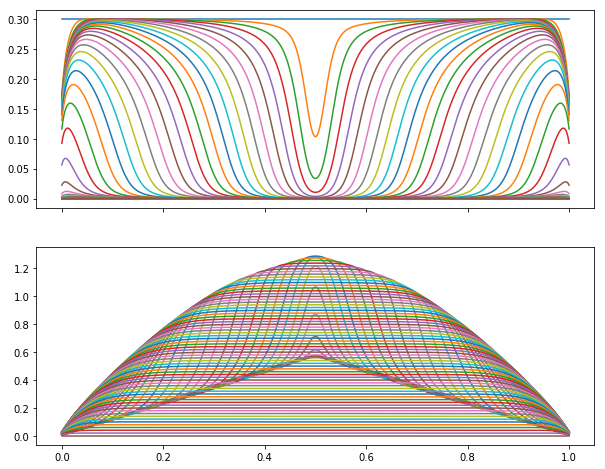

In [8]:
# Plot solution

plt.rcParams['figure.figsize'] = [10, 8]
plotevery=40
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(xvals, rhosave.T[:,::plotevery])
axarr[1].plot(xvals, -phisave.T[:,::plotevery])
plt.show()
